# Smart Mobility
## Etapa 1 - Rankeamento de Vias

### Cálculos realizados com dados referentes ao período de 01/20/2017 a 21/10/2018, das 07:00 às 09:00 e das 17:00 às 19:00.

In [1]:
%matplotlib inline
import os
import sys
project_dir = os.path.join(os.pardir, os.pardir)
sys.path.append(project_dir)

import dotenv
dotenv_path = os.path.join(project_dir, '.env')
dotenv.load_dotenv(dotenv_path)

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from matplotlib import pyplot as plt
from shapely.geometry import Point

from src.data.processing_func import (connect_database, extract_geo_sections)

pd.options.display.max_columns = 30

import folium

### Carregamento dos dados do Waze:

In [2]:
gdf = gpd.read_file(project_dir + "/data/interim/traffic_indicators_2017_10_1_14_weeks.geoJSON")
gdf.dropna(subset=["Rua"], inplace=True)
gdf["Codigo do Trecho"] = gdf["Codigo do Trecho"].astype(int)

#Lookup to change period for Período
lkp_period = pd.DataFrame({"Período": ["Manha", "Tarde"]}, index=[-1, 1])
gdf = gdf.join(lkp_period, on="period")
gdf.drop("period", axis=1, inplace=True)
cols = gdf.columns.tolist()
gdf = gdf[cols[:4] + [cols[-1]] + cols[4:-1]]

#Lookup to translate N/S, W/E directions
lkp_direction_NS = pd.DataFrame({"Sentido N/S": ["Norte", "Sul"]}, index=["North", "South"])
lkp_direction_LO = pd.DataFrame({"Sentido L/O": ["Leste", "Oeste"]}, index=["East", "West"])
lkp_direction = pd.DataFrame({"Sentido": ["Norte", "Sul", "Leste", "Oeste"]}, index=["North", "South", "East", "West"])

gdf = gdf.join(lkp_direction_NS, on="Direcao N/S")
gdf = gdf.join(lkp_direction_LO, on="Direcao L/O")
gdf = gdf.join(lkp_direction, on="Sentido", lsuffix='_left')
gdf.drop(labels="Sentido_left", axis=1, inplace=True)

#Drop negative Delays (if a section has negative)

#Creation of an indicator of traffic criticity
gdf["Criticidade"] = gdf["Probabilidade de Transito"]*gdf["Atraso medio (s)"]

print("Trechos avaliados: ", len(gdf))
print("Amostra: ")
gdf.drop("geometry", axis=1).sort_values("Criticidade", ascending=True).drop_duplicates("Rua").head(5)

Trechos avaliados:  12454
Amostra: 


,Codigo do Trecho,Codigo da Rua,Rua,CodArcgis,Período,Metrica,Direcao L/O,Direcao N/S,Probabilidade de Transito,Velocidade Media (km/h),Fila media (m),Atraso medio (s),Nivel medio de congestionamento (0 a 5),SctnDscCoordxUtmComeco,SctnDscCoordyUtmComeco,SctnDscCoordxUtmMeio,SctnDscCoordyUtmMeio,SctnDscCoordxUtmFinal,SctnDscCoordyUtmFinal,Sentido N/S,Sentido L/O,Sentido,Criticidade
12489,15165,29,ALBANO SCHMIDT,31559,Tarde,1655,West,North,0.004630,5.28,194.0,60.0,2.0,717874.2654,7.089707e+06,717845.676250,7.089678e+06,717817.0871,7.089650e+06,Norte,Oeste,Norte,0.277778
12488,6910,4015,GENERAL GOES MONTEIRO,23140,Tarde,541,West,North,0.004630,5.28,194.0,60.0,2.0,717817.0871,7.089650e+06,717788.468000,7.089672e+06,717759.8489,7.089694e+06,Norte,Oeste,Norte,0.277778
12486,10921,8671,SAO BORJA,27229,Tarde,1307,West,North,0.004630,18.80,867.0,61.0,1.0,718470.9323,7.088755e+06,718502.223250,7.088689e+06,718533.5142,7.088622e+06,Norte,Oeste,Norte,0.282407
12286,14386,1242,BOEHMERWALD,30770,Tarde,6089,East,South,0.004762,21.18,717.0,60.0,2.0,719983.0844,7.083113e+06,719960.322801,7.083285e+06,719926.0266,7.083456e+06,Sul,Leste,Leste,0.285714
12282,13210,7250,PONTE SERRADA,29578,Tarde,1346,West,South,0.004762,28.17,1670.0,60.0,1.0,719599.6983,7.092313e+06,719630.173350,7.092336e+06,719660.6484,7.092359e+06,Sul,Oeste,Oeste,0.285714


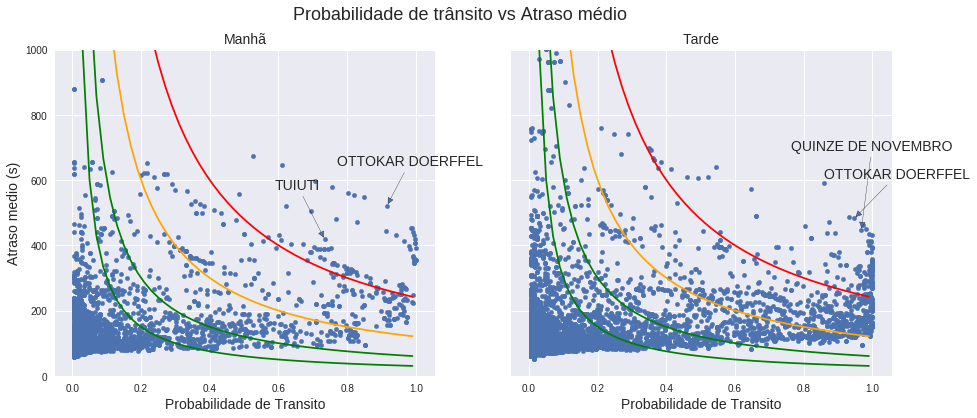

In [3]:
df = gdf.drop("geometry", axis=1)
plt.clf()
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(6)
f.set_figwidth(15)

df[df["Período"] == "Manha"].plot("Probabilidade de Transito", "Atraso medio (s)", kind="scatter", ax=ax1)
df[df["Período"] == "Tarde"].plot("Probabilidade de Transito", "Atraso medio (s)", kind="scatter", ax=ax2)

threshold_1 = 30
x = np.arange(0.01, 1.0, 0.02)
y = threshold_1/x
ax1.plot(x,y, color="green")
ax2.plot(x,y, color="green")

threshold_2 = 60
x = np.arange(0.01, 1.0, 0.02)
y = threshold_2/x
ax1.plot(x,y, color="green")
ax2.plot(x,y, color="green")

threshold_3 = 120
x = np.arange(0.01, 1.0, 0.02)
y = threshold_3/x
ax1.plot(x,y, color="orange")
ax2.plot(x,y, color="orange")

threshold_4 = 240
x = np.arange(0.01, 1.0, 0.02)
y = threshold_4/x
ax1.plot(x,y, color="red")
ax2.plot(x,y, color="red")

#Annotations - Morning
morning_critical = df[df["Período"] == "Manha"].sort_values("Criticidade", ascending=False).drop_duplicates("Rua")

first_order=0
first_morn_rua = morning_critical["Rua"].iloc[first_order]
first_morn_point = morning_critical[["Probabilidade de Transito", "Atraso medio (s)"]].iloc[first_order]

second_order=2
second_morn_rua = morning_critical["Rua"].iloc[second_order]
second_morn_point = morning_critical[["Probabilidade de Transito", "Atraso medio (s)"]].iloc[second_order]

ax1.annotate(first_morn_rua,
             xy=first_morn_point,
             xytext=(-50, 40),
             textcoords="offset points",
             arrowprops=dict(arrowstyle='-|>'),
             fontsize=14)

ax1.annotate(second_morn_rua,
             xy=second_morn_point,
             xytext=(-50, 50),
             textcoords="offset points",
             arrowprops=dict(arrowstyle='-|>'),
             fontsize=14)

#Annotations - Afternoon
aftern_critical = df[df["Período"] == "Tarde"].sort_values("Criticidade", ascending=False).drop_duplicates("Rua")

first_order=1
first_aftern_rua = aftern_critical["Rua"].iloc[first_order]
first_aftern_point = aftern_critical[["Probabilidade de Transito", "Atraso medio (s)"]].iloc[first_order]

second_order=2
second_aftern_rua = aftern_critical["Rua"].iloc[second_order]
second_aftern_point = aftern_critical[["Probabilidade de Transito", "Atraso medio (s)"]].iloc[second_order]

ax2.annotate(first_aftern_rua,
             xy=first_aftern_point,
             xytext=(-30, 40),
             textcoords="offset points",
             arrowprops=dict(arrowstyle='-|>'),
             fontsize=14)

ax2.annotate(second_aftern_rua,
             xy=second_aftern_point,
             xytext=(-70, 80),
             textcoords="offset points",
             arrowprops=dict(arrowstyle='-|>'),
             fontsize=14)


ax1.set_ylim([0,1000])
ax1.set_title("Manhã", fontsize=14)
ax2.set_title("Tarde", fontsize=14)
ax1.xaxis.label.set_size(14)
ax1.yaxis.label.set_size(14)
ax2.xaxis.label.set_size(14)
ax2.yaxis.label.set_size(14)


fig = plt.gcf()
fig.suptitle("Probabilidade de trânsito vs Atraso médio", fontsize=18)

plt.show()

### Classificação Funcional das vias

In [4]:
arteriais = pd.read_csv(project_dir + "/data/external/sepud_vias_arteriais.csv", sep=";")
coletoras = pd.read_csv(project_dir + "/data/external/sepud_vias_coletoras.csv", encoding="Latin-1", sep=";")

arteriais.drop_duplicates(["nomelog", "tipo_via_"], inplace=True)
coletoras.drop_duplicates(["nomelog", "tipo_via_"], inplace=True)

arteriais = arteriais[["nomelog", "tipo_via_"]]
coletoras = coletoras[["nomelog", "tipo_via_"]]

arteriais["ClassFunc score"] = 10
coletoras["ClassFunc score"] = 6

class_func = arteriais.append(coletoras)
class_func.set_index("nomelog", inplace=True)
class_func.rename(columns={"tipo_via_": "ClassFunc"}, inplace=True)

gdf_clf = gdf.join(class_func, on="Rua")
gdf_clf["ClassFunc"].fillna(value="LOCAL/OUTRO", inplace=True)
gdf_clf["ClassFunc score"].fillna(value=1, inplace=True)
gdf_clf["ClassFunc score"] = gdf_clf["ClassFunc score"].astype(int)

#Manual Corrections
gdf_clf.loc[gdf_clf["Rua"] == "OTTO PARUCKER", "ClassFunc"] = "ARTERIAL"
gdf_clf.loc[gdf_clf["Rua"] == "OTTO PARUCKER", "ClassFunc score"] = 5

gdf_clf.loc[gdf_clf["Rua"] == "CAMBORIU", "ClassFunc"] = "ARTERIAL"
gdf_clf.loc[gdf_clf["Rua"] == "CAMBORIU", "ClassFunc score"] = 5

print("Amostra:")
gdf_clf[["Codigo do Trecho", "Rua", "ClassFunc", "ClassFunc score"]].head()

Amostra:


,Codigo do Trecho,Rua,ClassFunc,ClassFunc score
0,2388,OTTOKAR DOERFFEL,ARTERIAL,10
1,8738,OTTOKAR DOERFFEL,ARTERIAL,10
2,14047,OTTOKAR DOERFFEL,ARTERIAL,10
3,2389,OTTOKAR DOERFFEL,ARTERIAL,10
4,8322,FLORIANOPOLIS,ARTERIAL,10


### Acidentes 2015

In [5]:
DATABASE = {
'drivername': os.environ.get("db_drivername"),
'host': os.environ.get("db_host"), 
'port': os.environ.get("db_port"),
'username': os.environ.get("db_username"),
'password': os.environ.get("db_password"),
'database': os.environ.get("db_database"),
}

#Load GeoSections
if 'geo_sections' not in globals():
    meta = connect_database(DATABASE)
    geo_sections = extract_geo_sections(meta, main_buffer=15)

#Read acidentes and convert it into GeoDataFrame
accidents = pd.read_csv(project_dir + "/data/external/bombeiros_acidentes2015.csv")
accidents["geometry"] = accidents.apply(
                                    lambda row: Point(row["X"], row["Y"]), axis=1)
crs = "+proj=utm +zone=22J, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
geo_accidents = gpd.GeoDataFrame(accidents, crs=crs, geometry="geometry")
geo_accidents = geo_accidents.to_crs({'init': 'epsg:4326'})
geo_accidents = gpd.sjoin(geo_accidents, geo_sections, how="left", op="within")

accidents_per_section = geo_accidents.groupby("SctnId").agg({'id': 'count'})
accidents_per_section.rename(columns={"id": "Numero de Acidentes 2015"}, inplace=True)
accidents_per_section.index = accidents_per_section.index.astype(int)
accidents_per_section.sort_values('Numero de Acidentes 2015', ascending=False, inplace=True)

gdf_acc = gdf_clf.join(accidents_per_section, on="Codigo do Trecho")
gdf_acc["Numero de Acidentes 2015"].fillna(value=0, inplace=True)

gdf_acc["Acidentes score"] = pd.cut(gdf_acc["Numero de Acidentes 2015"], bins=5, labels=[1,2,3,4,5], retbins=True)[0].astype(int)

print("Amostra:")
gdf_acc[["Codigo do Trecho", "Rua", "Numero de Acidentes 2015", "Acidentes score"]].head(5)

Amostra:


,Codigo do Trecho,Rua,Numero de Acidentes 2015,Acidentes score
0,2388,OTTOKAR DOERFFEL,1.0,1
1,8738,OTTOKAR DOERFFEL,1.0,1
2,14047,OTTOKAR DOERFFEL,1.0,1
3,2389,OTTOKAR DOERFFEL,0.0,1
4,8322,FLORIANOPOLIS,3.0,1


### Metodologia de Rankeamento

In [6]:
gdf_acc["Transito score"] = pd.cut(gdf_acc["Criticidade"],
                                   bins=[0, threshold_1,threshold_2,threshold_3,threshold_4, 5*threshold_4],
                                   labels=[1,2,3,4,5], retbins=True)[0].astype(int)*3

gdf_acc["Total score"] = gdf_acc["Transito score"] + gdf_acc["ClassFunc score"] + gdf_acc["Acidentes score"]

gdf_acc.sort_values(["Total score", "Probabilidade de Transito"], ascending=False, inplace=True)

col_list = ["Codigo do Trecho", "Codigo da Rua", "Rua", "CodArcgis", "Metrica", "Sentido",
            "Período", "Transito score", "ClassFunc score", "Acidentes score", "Total score",
            "Probabilidade de Transito", "Velocidade Media (km/h)",
            "Fila media (m)", "Atraso medio (s)", "ClassFunc", "Numero de Acidentes 2015",
           "SctnDscCoordxUtmComeco", "SctnDscCoordyUtmComeco", "SctnDscCoordxUtmMeio",
           "SctnDscCoordyUtmMeio", "SctnDscCoordxUtmFinal", "SctnDscCoordyUtmFinal",
           ]
print("Os 10 trechos mais críticos de Joinville: ")
gdf_acc[col_list].head(10)

Os 10 trechos mais críticos de Joinville: 


,Codigo do Trecho,Codigo da Rua,Rua,CodArcgis,Metrica,Sentido,Período,Transito score,ClassFunc score,Acidentes score,Total score,Probabilidade de Transito,Velocidade Media (km/h),Fila media (m),Atraso medio (s),ClassFunc,Numero de Acidentes 2015,SctnDscCoordxUtmComeco,SctnDscCoordyUtmComeco,SctnDscCoordxUtmMeio,SctnDscCoordyUtmMeio,SctnDscCoordxUtmFinal,SctnDscCoordyUtmFinal
353,718,9288,TUIUTI,16832,5154,Norte,Manha,15,10,3,28,0.957136,7.715687,612.013347,262.557480,ARTERIAL,12.0,717992.7160,7.096494e+06,717946.579475,7.096882e+06,717909.6821,7.097272e+06
6,8839,9288,TUIUTI,25102,5590,Sul,Tarde,15,10,2,27,0.999986,6.674238,723.201867,390.616256,ARTERIAL,9.0,717735.4477,7.097672e+06,717822.564900,7.097472e+06,717909.6821,7.097272e+06
21,7919,6936,OTTOKAR DOERFFEL,24163,826,Oeste,Tarde,15,10,2,27,0.999872,9.487426,1119.554859,335.334542,ARTERIAL,5.0,713416.5257,7.087636e+06,713455.433796,7.087680e+06,713495.1530,7.087723e+06
104,8002,71,ANITA GARIBALDI,24246,1021,Leste,Tarde,15,10,2,27,0.997507,12.322121,1338.955027,269.408758,ARTERIAL,6.0,714303.5933,7.086922e+06,714361.037200,7.086982e+06,714418.4811,7.087043e+06
112,4919,3723,FLORIANOPOLIS,21091,2152,Leste,Tarde,15,10,2,27,0.996971,15.636933,1487.216961,241.280060,ARTERIAL,7.0,717103.4441,7.085779e+06,717150.292300,7.085764e+06,717197.1405,7.085749e+06
142,4920,3723,FLORIANOPOLIS,21092,2054,Leste,Tarde,15,10,2,27,0.994100,15.512627,1539.059007,253.805946,ARTERIAL,8.0,717001.6531,7.085812e+06,717052.548600,7.085796e+06,717103.4441,7.085779e+06
167,4824,129,CEL. PROCOPIO GOMES,20996,1669,Sul,Tarde,15,10,2,27,0.992568,8.159576,825.934193,309.734163,ARTERIAL,6.0,715567.1587,7.087207e+06,715570.627650,7.087100e+06,715574.0966,7.086993e+06
176,5108,129,CEL. PROCOPIO GOMES,21281,1281,Sul,Tarde,15,10,2,27,0.991706,8.265681,857.671349,319.805096,ARTERIAL,5.0,715559.7027,7.087500e+06,715560.935050,7.087440e+06,715562.1674,7.087380e+06
189,14195,2650,DONA FRANCISCA,30578,4677,Norte,Manha,15,10,2,27,0.990862,10.104307,1133.722146,366.366968,ARTERIAL,6.0,713922.1024,7.092878e+06,713955.343650,7.092859e+06,713988.5849,7.092841e+06
198,843,130,GETULIO VARGAS,16954,112,Sul,Tarde,15,10,2,27,0.989205,9.581099,1180.703484,337.233990,ARTERIAL,6.0,715065.0183,7.088486e+06,715066.788200,7.088430e+06,715068.5581,7.088374e+06


In [7]:
gdf_ruas = gdf_acc.drop_duplicates("Rua")

print("As 10 ruas mais críticas de Joinville:")
gdf_ruas[col_list].head(10)

As 10 ruas mais críticas de Joinville:


,Codigo do Trecho,Codigo da Rua,Rua,CodArcgis,Metrica,Sentido,Período,Transito score,ClassFunc score,Acidentes score,Total score,Probabilidade de Transito,Velocidade Media (km/h),Fila media (m),Atraso medio (s),ClassFunc,Numero de Acidentes 2015,SctnDscCoordxUtmComeco,SctnDscCoordyUtmComeco,SctnDscCoordxUtmMeio,SctnDscCoordyUtmMeio,SctnDscCoordxUtmFinal,SctnDscCoordyUtmFinal
353,718,9288,TUIUTI,16832,5154,Norte,Manha,15,10,3,28,0.957136,7.715687,612.013347,262.557480,ARTERIAL,12.0,717992.7160,7.096494e+06,717946.579475,7.096882e+06,717909.6821,7.097272e+06
21,7919,6936,OTTOKAR DOERFFEL,24163,826,Oeste,Tarde,15,10,2,27,0.999872,9.487426,1119.554859,335.334542,ARTERIAL,5.0,713416.5257,7.087636e+06,713455.433796,7.087680e+06,713495.1530,7.087723e+06
104,8002,71,ANITA GARIBALDI,24246,1021,Leste,Tarde,15,10,2,27,0.997507,12.322121,1338.955027,269.408758,ARTERIAL,6.0,714303.5933,7.086922e+06,714361.037200,7.086982e+06,714418.4811,7.087043e+06
112,4919,3723,FLORIANOPOLIS,21091,2152,Leste,Tarde,15,10,2,27,0.996971,15.636933,1487.216961,241.280060,ARTERIAL,7.0,717103.4441,7.085779e+06,717150.292300,7.085764e+06,717197.1405,7.085749e+06
167,4824,129,CEL. PROCOPIO GOMES,20996,1669,Sul,Tarde,15,10,2,27,0.992568,8.159576,825.934193,309.734163,ARTERIAL,6.0,715567.1587,7.087207e+06,715570.627650,7.087100e+06,715574.0966,7.086993e+06
189,14195,2650,DONA FRANCISCA,30578,4677,Norte,Manha,15,10,2,27,0.990862,10.104307,1133.722146,366.366968,ARTERIAL,6.0,713922.1024,7.092878e+06,713955.343650,7.092859e+06,713988.5849,7.092841e+06
198,843,130,GETULIO VARGAS,16954,112,Sul,Tarde,15,10,2,27,0.989205,9.581099,1180.703484,337.233990,ARTERIAL,6.0,715065.0183,7.088486e+06,715066.788200,7.088430e+06,715068.5581,7.088374e+06
491,2909,4057,GUANABARA,19056,2568,Oeste,Manha,15,10,2,27,0.911172,10.868155,964.983591,290.803098,ARTERIAL,8.0,717794.2296,7.087082e+06,717896.817850,7.087045e+06,717999.4061,7.087008e+06
811,15890,7263,PREFEITO HELMUT FALLGATTER,22055,408,Oeste,Manha,15,10,2,27,0.788727,15.614353,1703.439189,308.431522,ARTERIAL,6.0,716358.7605,7.088541e+06,716455.816776,7.088551e+06,716553.3004,7.088557e+06
70,9282,8274,QUINZE DE NOVEMBRO,25560,4410,Oeste,Tarde,15,10,1,26,0.998695,11.891033,1289.784218,344.695631,ARTERIAL,1.0,711545.2532,7.089831e+06,711574.716746,7.089903e+06,711601.0300,7.089977e+06


In [8]:
gdf_acc[col_list].to_excel(project_dir + "/data/processed/indicadores_transito.xlsx")

In [15]:
gdf_acc[gdf_acc["ClassFunc"] == "LOCAL/OUTRO"][col_list] \
                                              .sort_values(["Probabilidade de Transito",
                                                            "Atraso medio (s)"], ascending=False) \
                                              .to_excel(project_dir + "/data/interim/locais_priorizadas.xlsx")

In [10]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Clique para mostrar/ocultar código."></form>''')